# <center>Regressor: band gap</center>
---

In [35]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
%matplotlib notebook
pd.set_option('display.max_columns', None)

First, load in the training sets generated in `dataset.ipynb`.

In [27]:
X = pd.read_csv('../data/X_train_r.csv')
y = pd.read_csv('../data/y_train_r.csv')

### Inputs: structural and compositional features

In [28]:
X.head(5)

,minimum CN_VoronoiNN,maximum CN_VoronoiNN,mean CN_VoronoiNN,max relative bond length,minimum neighbor distance variation,maximum neighbor distance variation,mean ordering parameter shell 1,minimum local difference in Number,maximum local difference in Number,minimum local difference in MendeleevNumber,maximum local difference in MendeleevNumber,minimum local difference in MeltingT,maximum local difference in MeltingT,minimum local difference in CovalentRadius,maximum local difference in CovalentRadius,maximum local difference in Electronegativity,minimum local difference in NsValence,maximum local difference in NsValence,maximum local difference in NpValence,range local difference in NpValence,minimum local difference in NdValence,maximum local difference in NdValence,minimum local difference in NfValence,maximum local difference in NfValence,minimum local difference in NValence,maximum local difference in NValence,minimum local difference in NpUnfilled,maximum local difference in NpUnfilled,range local difference in NpUnfilled,minimum local difference in NdUnfilled,maximum local difference in NdUnfilled,minimum local difference in NfUnfilled,maximum local difference in NfUnfilled,minimum local difference in NUnfilled,maximum local difference in NUnfilled,minimum local difference in GSvolume_pa,maximum local difference in GSvolume_pa,minimum local difference in GSbandgap,maximum local difference in GSbandgap,minimum local difference in GSmagmom,maximum local difference in GSmagmom,maximum local difference in SpaceGroupNumber,0-norm,2-norm,MagpieData minimum Number,MagpieData maximum MendeleevNumber,MagpieData mode MendeleevNumber,MagpieData minimum MeltingT,MagpieData mean MeltingT,MagpieData maximum Column,MagpieData mean Column,MagpieData mode Column,MagpieData maximum NsValence,MagpieData minimum NpValence,MagpieData minimum NdValence,MagpieData minimum NfValence,MagpieData mode NfValence,MagpieData minimum NValence,MagpieData mode NsUnfilled,MagpieData mean NpUnfilled,MagpieData mode NpUnfilled,MagpieData minimum NdUnfilled,MagpieData mode NdUnfilled,MagpieData minimum NfUnfilled,MagpieData mode NfUnfilled,MagpieData minimum NUnfilled,MagpieData mode NUnfilled,MagpieData minimum GSbandgap,MagpieData minimum GSmagmom,MagpieData mode GSmagmom,MagpieData maximum SpaceGroupNumber,frac p valence electrons,compound possible
0,4.324371,9.071555,6.549731,1.260702,0.060014,0.411866,0.718764,1.940729,3.150994,14.724034,80.165951,309.791530,2253.453405,17.667687,94.280900,2.343810,0.000577,0.959121,3.729026,1.612213,0.000000,0.0,0.000000,0.0,2.292896,4.667262,1.764646,3.072777,1.308131,0.000000,0.0,0.0,0.0,0.962154,2.994561,1.904477,19.490211,0.012151,1.503852,0.0,0.000000,202.369398,3,0.638971,5.0,87.0,87.0,54.8,809.026154,16.0,12.769231,16.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,2.615385,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,229.0,0.571429,True
1,5.827764,10.254544,7.966235,1.084625,0.009890,0.176181,0.564152,35.161896,64.871012,23.078308,40.186026,1339.774909,2448.206943,60.644945,107.186026,1.994882,0.000000,0.000000,3.637205,1.707232,1.091607,2.0,7.641249,14.0,6.780115,12.871012,1.322080,2.871012,1.548932,4.366428,8.0,0.0,0.0,3.156131,5.637205,4.929811,11.040221,1.483555,5.784725,0.0,0.000000,176.907150,3,0.600000,7.0,87.0,45.0,54.8,1038.580000,16.0,10.800000,4.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,1.600000,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,194.0,0.192308,True
2,5.747704,12.153480,9.087191,1.117000,0.066680,0.174321,0.551105,2.070534,14.227174,34.310421,89.958734,315.230405,2129.197265,46.401911,107.603117,2.987129,0.000023,0.994277,4.887462,2.758785,0.000000,3.0,0.000000,0.0,1.772826,5.881461,0.621937,1.260906,0.638969,0.000000,7.0,0.0,0.0,0.082535,5.772780,3.439699,19.584624,0.614853,1.795585,0.0,0.000000,214.676705,4,0.586302,8.0,93.0,93.0,53.5,399.192500,17.0,11.375000,17.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.750000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,229.0,0.585366,False
3,4.337782,10.869277,8.652471,1.156517,0.058613,0.228676,0.68649

### Output: band gap

Let's visualize how the band gap values are distributed.

<IPython.core.display.Javascript object>


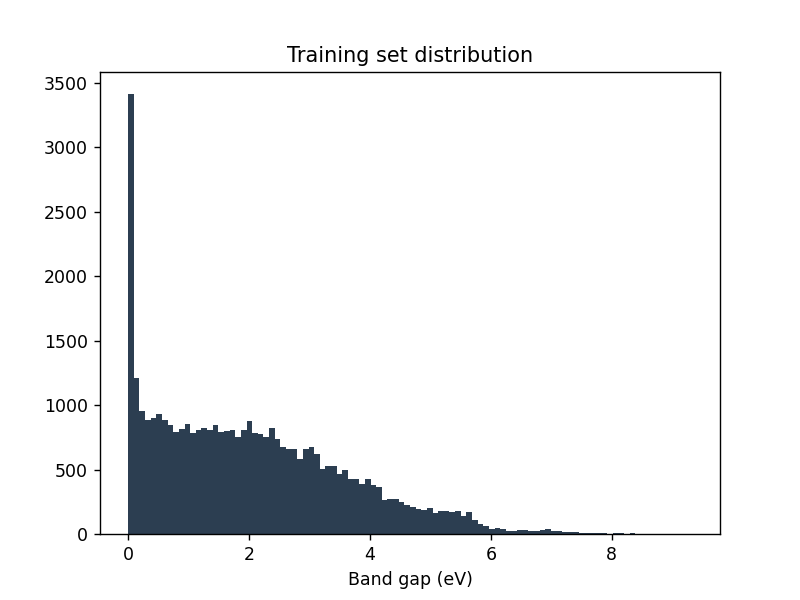

In [29]:
plt.figure()
plt.hist(y['gap pbe'], color = '#2C3E51', bins = 100)
plt.xlabel('Band gap (eV)')
plt.title('Training set distribution');

The large number of materials with a very small band gap will likely affect the performance of the model. In the future, it should be given more consideration, but for now it is left alone.

### Training

In [25]:
def regression(model_type, par_dict, X_train, y_train):
    '''
    The skeleton used for training a regressor.
    INPUTS: 
        model_type -- A scikit-learn estimator object.
        par_dict -- The dict of parameters used for CV.
        X_train -- the input of the training set.
        y_train -- the ouput of the training set.
    OUTPUT:
        A trained scikit-learn model.
    '''
    rscv = RandomizedSearchCV(
            estimator = model_type, 
            param_distributions = par_dict, 
            scoring="neg_mean_squared_error",
            verbose = 2, 
            random_state = 42, 
            n_jobs = -1
    )
    rscv.fit(X_train, y_train.values.ravel())
    print(rscv.best_params_)
    model = rscv.best_estimator_
    model.fit(X_train, y_train.values.ravel())
    return model

Let's consider both linear and non-linear models.

In [38]:
choices = [
    [KernelRidge(), {'alpha': np.logspace(-6, 3, 10), 'gamma': np.logspace(-5, 5, 10), 'kernel': ['rbf', 'laplacian']}],
    [KNeighborsRegressor(), {'n_neighbors': [int(x) for x in np.linspace(1, 20, 10)]}],
    [Lasso(), {'alpha': np.logspace(-1, 10, 10)}],
    [MLPRegressor(), {'hidden_layer_sizes':[(10,10,10),(15,15,15),(20,20)], "alpha": [0.00001,0.0001,0.001,0.01]}],
    [RandomForestRegressor(), {'n_estimators': [int(x) for x in np.linspace(200, 1000, 5)] + [1500, 2000], 'max_depth': [int(x) for x in np.linspace(5, 55, 11)] + [None], 'max_features': ['auto', 'sqrt', 'log2'], 'criterion': ['mse', 'mae'], 'min_samples_split': [int(x) for x in np.linspace(2, 10, 9)], 'min_impurity_decrease': [0.0, 0.05, 0.1]}],
    [SVR(), {'C': np.logspace(-1, 5, 10), 'gamma': np.logspace(-5, 5, 10)}]
]

The next cell trains all models and writes them to `pickle` files in the `jar`. Of course, with a dataset of this size, running it locally would take forever. Hence, I trained all of the models on HPC clusters.

In [ ]:
for choice in choices:
    filename = str(choice[0])[:-2] + '_trained.p'
    trained_model = classify(choice[0], choice[1], X, y)
    pickle.dump(trained_model, open('../jar/regressor/' + filename, 'wb'))